+++ 
date = "2019-03-04"
title = "Classical Speech Enhancement Part 1: Spectral subtraction"
markup = "mmark"
+++

This is part 1 in a series of three posts that implement three classical DSP methods of enhancing speech in audio recordings in Python. It uses slides and re-implements code from a source separation tutorial that can be found [here](https://ccrma.stanford.edu/~njb/teaching/sstutorial/). The post is largely a narration of the material in the link. The three methods are spectral subtraction, Wiener filtering and probabilistic estimation (Ephraim-Malah). 

## The general framework

The speech enhancement problem is posed as a source separation problem - given a mixture of noise ($d[n]$) and signal ($x[n]$), separate the two. We model the given audio in the frequency space as: $Y(\omega) = X(\omega) + D(\omega)$

To convert the original audio sequence $y[n]$ into $Y(\omega)$, we first convert it into a sequence of overlapping frames. Each frame indexed by $m$ has $M$ samples and an overlap determined by $R$ eg. if $R = M/2$, we have 50% overlap. We take each frame's fourier transform using the FFT to get $Y_{m}(\omega)$. Then our goal is to estimate $X_{m}(\omega)$ as $\hat{X}_{m}(\omega)$. We can reconstruct the desired audio $\hat{x}[n]$ using  an inverse FFT and overlap-add.

![image.png](img/general_framework.png)

The speech enhancement challenge is reduced to (step 1) modeling of our noise $D(\omega)$ and (step 2) estimation of $X(\omega)$ i.e $\hat{X}(\omega)$. 

One approach to modeling the noise is to assume that noise is slowly varying compared to speech. Using a voice activity detector, we can tell what frames do not have speech, and estimate $D(\omega)$ from those frames (eg. by averaging). We will look at one example of estimating the noise in the next section.

The general algorithm for producing the magnitude of the signal estimate $|\hat{X}(\omega)|$ can be reduced to designing a gain curve $H_{m}(\omega) = |\hat{X}_{m}(\omega)|/|Y_{m}(\omega)|$. i.e for each $m$th audio frame $Y_{m}(\omega)$, we derive the estimate $|\hat{X}_{m}(\omega)|$ by multiplying by a gain curve: $|\hat{X}_{m}(\omega)| = |H_{m}(\omega)| |Y_{m}(\omega)|$. The gain curve $H_{m}(\omega)$ determines the scaling factors (or gains) for each spectral component $\omega$. The three different methods, as we'll see soon, provide different gain curves depending on different assumptions which lead to varying subjective results in speech enhancement.

## Step 1) Noise estimation

Given the noisy signal alone, how do we extract the properties of the noise? Specifically, how do we estimate the noise power spectrum?

Our goal is to estimate the noise magnitude $|D_{m}(\omega)|$ given only $|Y_{m}(\omega)|$. We can model the noise spectrum as slowly varying compared to the speech spectrum. With this assumption, one simple approach to noise estimation is performing a running mean on the input signal $|Y(\omega)|$. 

The running mean computation is best described as a low-pass filter - it only allows the slowly varying (low frequency) components to pass through. The parameter of concern for the running mean is the time duration over which to compute the running mean i.e the time window $\tau$ corresponding to $N$ samples.

The simplest running mean implementation (also called low-pass filter or moving average) is perhaps the box-car filter or simple moving average (SMA). At each timestep, it computes the mean over the last $N$ signal samples; this requires storing $N$ signal samples in a FIFO (first in first out) buffer which can be very memory intensive for large values of $N$. Note that the output of the box-car filter depends only on the past N input signal samples. It is an example of an FIR (finite impulse response) filter; the impulse response of the filter has a finite length $N$. 

A less memory intensive but equally effective running mean filter is the exponential moving average (EMA) or a single-pole IIR (infinite impulse response) filter. The EMA filter uses recursion -- the output of the filter depends on the previous output and the current input sample. This allows the filter to express a frequency response similar to the SMA but requiring a FIFO buffer of size 1. The output of the filter is given by the equation

$$ y[n] = (1 - \alpha) x[n] + \alpha y[n-1] $$

$\alpha$ is the parameter that determines the running mean window length $\tau$. In the box-car filter $T$ was defined as the number of samples contained in T seconds. For the IIR filter we define $T$ as the time for the output of the filter to reach 63.5% of the input step signal. $\alpha = \exp^{-\Delta T / \tau}$ where $\Delta T$ is the sampling interval.

The frequency response of the SMA and EMA is presented below for comparison:

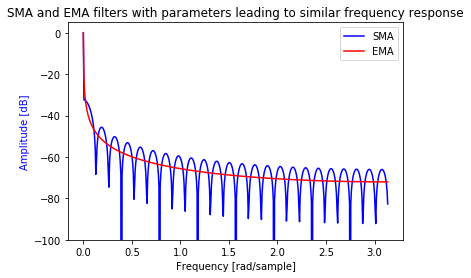

In [10]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 200 # sample rate in Hz
tau = 10 # time window in seconds for mean computation

# Boxcar/SMA filter params
N = int(tau*fs) # Number of samples corresponding to tau
h_boxcar = np.ones(N)/N  # impulse response of boxcar filter

# EMA filter params
alpha = np.exp(-1/(fs*tau))
a_ema = [1, -alpha] # Denominator
b_ema =  1 - alpha # Numerator

w, h = signal.freqz(h_boxcar)
plt.plot(w, 20 * np.log10(abs(h)), 'b')

w, h = signal.freqz(b_ema, a_ema)
plt.plot(w, 20 * np.log10(abs(h)), 'r')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.ylim(-100, 5);
plt.legend(['SMA', 'EMA']);
plt.title('SMA and EMA filters with parameters leading to similar frequency response');

Thus by choosing an appropriate value for $\alpha$, we can estimate the noise spectrum as the output of the EMA. Note that we have as many scalar EMA filters as there are spectral components $\omega$s. 

This approach doesn't make a distinction between frames containing speech and those that don't i.e the noise estimate includes pieces of the speech signal as well. We could use a voice activity detector to only update the EMA filter output for non-speech frames. 

Another approach described in "Adaptive noise estimation algorithm for speech enhancement" does something to that effect. It makes $\alpha$ for each frame $m$ in the EMA equation a sigmoidal function of the a-posteriori SNR: $\alpha(m) = 1/(1+\exp^{-a (SNR(m) - T)})$. The SNR is estimated by $|Y_m(\omega)|^{2}/E[D_{m-1}(\omega)]$ where $E[D_{m-1}(\omega)]$ is the average of the noise estimates of the previous 5-10 frames. The SNR is called a-posteriori because it is a ratio of the signal+noise power to noise power (as opposed to a-priori which is signal power to noise power). Notice that $SNR_{a-posteriori} = SNR_{a-priori} + 1$. 

![image.png](img/alpha_snr_noise_estimation.png)

The SNR estimation can be interpreted as measuring how much noise there is in each frame. When $SNR_{a-posteriori}$ is close to 1, the frame contains noise only and for values greater than 1, the frame contains speech+noise. Specfically, if at frame $m$ the $|Y_m(\omega)|^2 \to E[D_{m-1}(\omega)]$ i.e the spectrum is similar to the noise spectrum, SNR is close to 1 and $\alpha(m) \to 0$; the noise estimate is closer to the current frame's spectrum (there is a larger weighting to the current frame). 

## Step 2) Estimating the signal

What we get from step 1 is for every frame $m$ an estimate of the average value of the noise spectrum $E[D_{m}(\omega)]$ for each frequency bin $\omega$. How do we use it to estimate the signal?

### Magnitude spectral subtraction

The simplest approach is to subtract the input signal from the noise estimate to get the signal estimate $\hat{X}(\omega)$. Since the magnitude of $\hat{X}(\omega)$ needs to be non-negative, we rectify the difference using the max operator. The phase of the estimate is retained as the same as the input signal $Y(\omega)$.  

![image.png](img/mag_spectral_subtraction.png)

### Power spectral subtraction

The power spectral subtraction is a generalization of magnitude spectral subtraction where we take the $\alpha$th power for each of the magnitude terms.

![image.png](img/power_spectral_subtraction.png)

Re-formulating the above formula to put it in the Gain curve setup, we get 

![image.png](img/gain_spectral_subtraction.png)

![image.png](img/gain_curve_spectral_subtraction.png)

With both steps in place, let's put them together on real audio samples.

In [2]:
""" Begin with utility functions to convert the given audio into a list of audio-frames and back"""

# Using scipy's stft/istft function; see scipy's stft source code for details
def audio_to_frames(y: np.array, m, hop_size, fs) -> np.array:
    """Convert y[n] into a matrix of frames Y_m(w) where each row is a time slice"""   
    _, _, Zxx = signal.stft(y, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return Zxx.T

def frames_to_audio(Y: np.array, m, hop_size, fs) -> np.array:
    """Convert Y_m(w) matrix of frames into a 1D signal y[n] using Overlap-Add"""
    _, xrec = signal.istft(Y.T, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return xrec

In [3]:
""" Generate the noisy speech signal from a clean speech signal by adding noise"""
import librosa 

speech_file = "wav/input/female2.wav"
noise_file = "wav/input/noise_white.wav"

x, fs = librosa.load(speech_file, sr=16000)
n, fs_noise = librosa.load(noise_file, sr=16000)

noise_gain = 0.7
n = noise_gain * n[:len(x)]

y = x + n

# Compute the SNR for signal x to noise n
y_snr = 10*np.log10(np.sum(x**2)/np.sum(n**2))
print("SNR: {:.2f}dB".format(y_snr))

SNR: 21.17dB


In [4]:
"""Convert the signal into overlapping frames and take Short-time Fourier Transform (STFT)"""
win_t = 30e-3 # window size in seconds
win_s = round(fs*win_t) # window size in samples
hop_size = win_s//2
Y = audio_to_frames(y, win_s, hop_size, fs)

In [5]:
""" (Step 1) Implement the adaptive noise estimation algorithm for speech enhancement"""
def noise_estimation_snr(Y: np.array) -> (np.array, np.array):
    """Estimates the magnitude and power spectrum of the noise for each frame"""
    
    # Prepare the output variables
    est_Mn = np.zeros(Y.shape)
    est_Pn = np.zeros(Y.shape)
    
    N = 10 # Number of frames to use for estimating a-posteriori SNR
    
    # Iterate through each frame and estimate noise
    for m in range(Y.shape[0]):
        if m < N:
            # Use noisy spectra for first 10 iterations
            est_Mn[m] = abs(Y[m])
            est_Pn[m] = est_Mn[m] ** 2
        else:
            a = 25
            # A-posteriori SNR            
            gammak = (abs(Y[m])**2)/np.mean(abs(Y[m-N:m])**2, axis=0) 
            alpha = 1/(1+np.exp(-a*(gammak-1.5)))
            est_Mn[m] = alpha * abs(est_Mn[m-1]) + (1-alpha) * abs(Y[m])
            est_Pn[m] = alpha * (abs(est_Mn[m-1])**2) + (1-alpha) * (abs(Y[m])**2)
            
    return est_Mn, est_Pn
        
est_Mn, est_Pn = noise_estimation_snr(Y)

In [6]:
""" (Step 2) Estimate the clean signal from (a) the noisy signal and (b) estimate of the noise magnitude"""
def spec_subtract_mag(Y, est_Mn) -> np.array:
    est_magX = np.maximum(abs(Y) - est_Mn, 0)
    est_phaseX = np.angle(Y)
    est_Sx = est_magX * np.exp(1j*est_phaseX)
    return est_Sx

def spec_subtract_pow(Y, est_Pn) -> np.array:
    est_powX = np.maximum(abs(Y)**2 - est_Pn, 0)
    est_phaseX = np.angle(Y)
    est_Sx = np.sqrt(est_powX) * np.exp(1j*est_phaseX)
    return est_Sx

est_Sx_mag = spec_subtract_mag(Y, est_Mn)
est_Sx_pow = spec_subtract_pow(Y, est_Pn)

In [7]:
""" Reconstruction of the speech signal estimate """
from IPython.display import Audio
import IPython.display

# Noisy audio
print("Noisy audio")
IPython.display.display(Audio(y, rate=fs))

# Clean audio
print("Clean audio")
IPython.display.display(Audio(x, rate=fs))

# Estimate based on magnitude spectral subtraction
x_hat_mag = frames_to_audio(est_Sx_mag, win_s, hop_size, fs)[:len(x)]
print("Estimate based on magnitude spectral subtraction")
IPython.display.display(Audio(x_hat_mag, rate=fs))

# Estimate based on power spectral subtraction
x_hat_pow = frames_to_audio(est_Sx_pow, win_s, hop_size, fs)[:len(x)]
print("Estimate based on power spectral subtraction")
IPython.display.display(Audio(x_hat_pow, rate=fs))

Noisy audio


Clean audio


Estimate based on magnitude spectral subtraction


Estimate based on power spectral subtraction


## Musical Noise

Spectral subtraction results sound promising. It eliminates most of the white noise but introduces an annoying type of noise that can be attributed to lingering spectral peaks that were not cleaned out by the spectral subtraction. See the spectrogram below and how there are large isolated peaks/valleys. The isolated peaks lead to a very tonal sound we call musical noise.

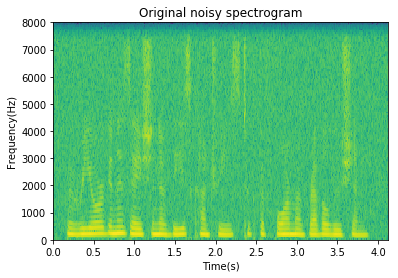

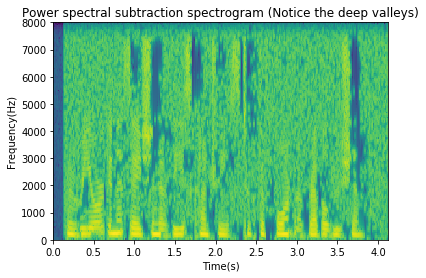

In [8]:
plt.specgram(y, Fs=fs);
plt.title('Original noisy spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(x_hat_pow, Fs=fs);
plt.title('Power spectral subtraction spectrogram (Notice the deep valleys)');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

There are two possible reasons for the spectral peaks leading to musical noise:
1. Inaccurate estimate of the noise. 

  We set the noise estimate $|\hat{D}_m(\omega)|^2$ to be $E|Y_m(\omega)|^2$. i.e $|\hat{D}_m(\omega)|^2$ = $E[|Y_m(\omega)|^2]$ = $E[|D_m(\omega)|^2]$. In other words, we compute a running average of the power spectra when there is no speech activity. Here we might get issues with inaccuracy of the voice activity detection. 
  
  The other inaccuracies might crop up due to the periodogram ($|Y_m(\omega)|$) itself. Let's take a quick detour in order to understand the purpose of the periodogram from a statistical standpoint. First, we think of a given $y[n]$ as being generated by a particular random process i.e we think of $y[n]$ as a time sequence of random variables with a particular joint probability distribution. When the joint probability distribution is time-invariant, the process is called stationary. We define two quantities: auto-correlation and power spectral density (PSD):
  The autocorrelation function is defined as the average value of the product of the signal and a time-shifted version of itself.
  
  $\phi_{xx}[m] = \mathbb{E}[x[m+n]x^{*}[n]]$
  
  For a stationary process like with our assumption, the PSD is the Fourier transform of the autocorrelation function ($\phi_{xx}[m]$). 
  
  $P(\omega) = \Phi_{xx}(e^{j\omega}) = \mathbb{F}[\{\phi_{xx}[m]\}]$
    
  When we are given a particular realization of a random process $y[n]$, the magnitude squared FFT of $y[n]$ turns out to be an emperical estimate of the PSD. You can try to prove this to yourselves (hint: magnitude squared of a complex number in the Fourier domain is a product of the complex number with its complex conjugate; in the time domain it is a convolution of the signal with a time reversed version of itself). 
  
  Therefore, the periodogram as we have used it in our code is a noisy emperical estimate of the PSD; it computes the PSD of the deterministic auto-correlation function. If we continue treating $y[n]$ as being generated by a random process, we can see than the periodogram is a function of a random variable which is also a random variable. Then we can look at the both the average value/expectation and variance of the periodogram. We can show that the mean of the periodogram is the PSD of the signal $y[n]$,  $\Phi(e^{j\omega})$ smeared by the deterministic PSD of the window function $W(e^{j\omega})$. The variance on the other hand is roughly the squared PSD: $var(P(\omega)) = \Phi_{xx}^2 (e^{j\omega})$. To summarize, the variance of the periodogram is large and can easily lead to a bad estimate. Averaging N periodograms helps reduce the variance by N but again (Welch's method), it can still be noisy.
  For non-stationary noise, the periodogram obviously does not give us a good estimate of the PSD either.
  

2. Inaccurate estimate of the signal. 
 
 The power spectral subtraction method itself needs some inspection. Remember, we half-wave recitify i.e use the max operator to make negative values clip to zero. This is a hacky solution to a real problem which arises when we have a bad noise estimate-- that magnitudes need to remain non-negative. This contributes to the presence of musical noise peaks.
 
## Oversubtraction & Spectral flooring

We can try to reduce the musical noise by some more engineering - (a) flooring: don't clip negative values to zero, instead fill in the "valleys" b) oversubtraction: reduce the musical noise peaks in the speech signal estimate by oversubtracting the noise estimate when we detect the presence of noise peaks. 

In equation form:

![image.png](img/oversubtraction.png)

$\alpha$ is the attenutation parameter for oversubtraction. It needs to be high when the a-posteriori SNR ($|Y_m(\omega)|^{2}/E[D_{m-1}(\omega)]$) is low and low when the SNR is high. 

![image.png](img/oversubtraction_alpha.png)

$\beta$ is a constant that needs to be sufficiently large to prevent deep valleys from forming. 

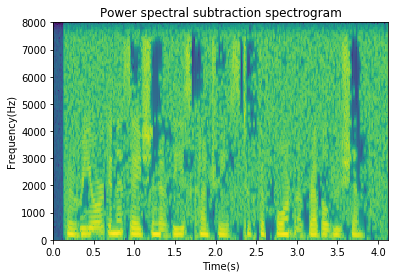

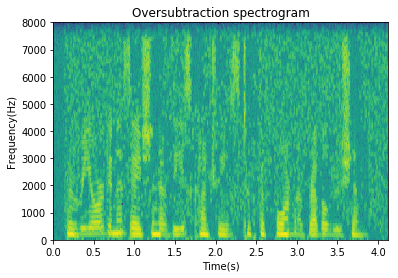

In [9]:
""" Oversubtraction + Spectral flooring """
def spec_oversubtract(Y, est_Pn):
    # Compute the alpha values for each frame
    snr = 10*np.log10(sum(abs(Y)**2)/sum(est_Pn))
    alpha = []
    for gamma in snr:  # Implement the purple curve above
        if gamma >= -5 and gamma <= 20:
            a = -6.25*gamma/25 + 6
            alpha.append(a)
        elif gamma > 20:
            alpha.append(1)
        else:
            alpha.append(7.25)
    beta = 0.002
    est_powX = np.maximum(abs(Y)**2 - alpha * est_Pn, beta * est_Pn) # Oversubtraction & spectral flooring
    est_phaseX = np.angle(Y)
    est_Sx = np.sqrt(est_powX) * np.exp(1j*est_phaseX)
    return est_Sx

est_Sx_oversub = spec_oversubtract(Y, est_Pn)

# Estimate based on oversubtraction and spectral flooring
x_hat_oversub = frames_to_audio(est_Sx_oversub, win_s, hop_size, fs)[:len(x)]
IPython.display.display(Audio(x_hat_oversub, rate=fs))


plt.specgram(x_hat_pow, Fs=fs);
plt.title('Power spectral subtraction spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(x_hat_oversub, Fs=fs);
plt.title('Oversubtraction spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

## Conclusion

The general framework to enhance a noisy speech audio file is to inspect it in the fourier domain -- see how the spectral components vary over time using the short-time Fourier Transform (STFT). In the fourier domain, estimate the noise as well as the signal and finally reconstruct the time-domain signal. 

We can estimate the noise is the fourier domain by taking a running mean of the noisy signal using the assumption that noise is changing slower than speech. We can enhance this technique by some measure for when there is speech and when there isn't. 

Magnitude, power and oversubtraction are three techniques that can then be used to recover the original signal. They have varying degrees of success with oversubtraction producing the least amount of artifacts. Next, we'll look at Weiner filtering within this general framework. 

This post is available in notebook form on my [github](https://github.com/Abhipray/embedded-sigproc/tree/master/content/posts/sigproc/classic_speech_enhancement).